# Analysis

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, trange
from visualization import *

### Data Loading

In [118]:
spark_metrics = pd.read_csv('../results/spark-metrics.csv')
appli_metrics = pd.read_csv('../results/appli-metrics.csv')

In [119]:
spark_metrics.head()

,jobId,jobGroup,stageId,index,launchTime,finishTime,duration,schedulerDelay,executorId,host,...,shuffleTotalBlocksFetched,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleWriteTime,shuffleBytesWritten,shuffleRecordsWritten,dataset,family,algorithm,run_id
0,4,NaN,6,43,1551697242585,1551697242823,238,5,3,172.16.48.12,...,0,0,0,0,0,0,drivface,regression,RandomForestRegressor,1
1,5,NaN,7,48,1551697243025,1551697243201,176,7,3,172.16.48.12,...,0,0,0,0,0,0,drivface,regression,RandomForestRegressor,1
2,5,NaN,7,53,1551697243027,1551697243203,176,8,3,172.16.48.12,...,0,0,0,0,0,0,drivface,regression,RandomForestRegressor,1
3,5,NaN,7,46,1551697243025,1551697243251,226,7,4,172.16.48.1,...,0,0,0,0,0,0,drivface,regression,RandomForestRegressor,1
4,5,NaN,7,51,1551697243026,1551697243251,225,6,4,172.16.48.1,...,0,0,0,0,0,0,drivface,regression,RandomForestRegressor,1


In [120]:
appli_metrics.head()

,metric,value,dataset,family,algorithm,run_id
0,transformTime,2344.000000,drivface,regression,RandomForestRegressor,1
1,fitTime,69992.000000,drivface,regression,RandomForestRegressor,1
2,mae,2.040848,drivface,regression,RandomForestRegressor,1
3,testCount,126.000000,drivface,regression,RandomForestRegressor,1
4,trainCount,480.000000,drivface,regression,RandomForestRegressor,1


### Applicative Metrics Analysis for Drugs Dataset

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


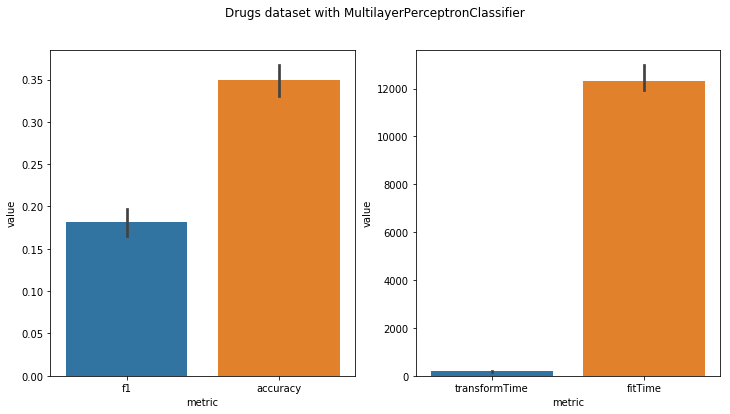

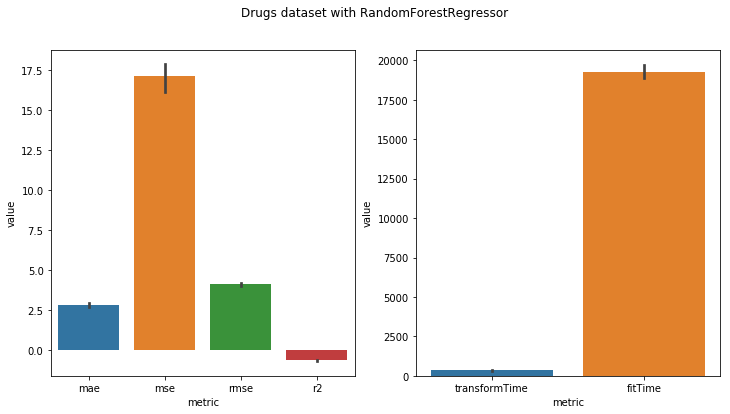

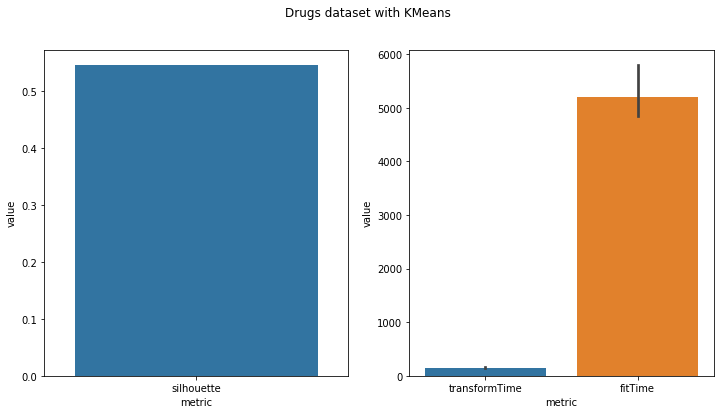

In [49]:
drugs = appli_metrics[appli_metrics['dataset'] == 'drugs']

drugs_mlp = drugs[drugs['algorithm'] == 'MultilayerPerceptronClassifier']

plt.figure(figsize=(12, 6))
plt.suptitle("Drugs dataset with MultilayerPerceptronClassifier")
plt.subplot(121)
sns.barplot(x='metric', y='value', data=drugs_mlp[np.isin(drugs_mlp['metric'], ['f1', 'accuracy'])])
plt.subplot(122)
sns.barplot(x='metric', y='value', data=drugs_mlp[np.isin(drugs_mlp['metric'], ['fitTime', 'transformTime'])])
plt.savefig('graphs/drugs_mlp.png')

drugs_rfr = drugs[drugs['algorithm'] == 'RandomForestRegressor']

plt.figure(figsize=(12, 6))
plt.suptitle("Drugs dataset with RandomForestRegressor")
plt.subplot(121)
sns.barplot(x='metric', y='value', data=drugs_rfr[np.isin(drugs_rfr['metric'], ['mae', 'mse', 'rmse', 'r2'])])
plt.subplot(122)
sns.barplot(x='metric', y='value', data=drugs_rfr[np.isin(drugs_rfr['metric'], ['fitTime', 'transformTime'])])
plt.savefig('graphs/drugs_rfr.png')

drugs_kme = drugs[drugs['algorithm'] == 'KMeans']

plt.figure(figsize=(12, 6))
plt.suptitle("Drugs dataset with KMeans")
plt.subplot(121)
sns.barplot(x='metric', y='value', data=drugs_kme[np.isin(drugs_kme['metric'], ['silhouette'])])
plt.subplot(122)
sns.barplot(x='metric', y='value', data=drugs_kme[np.isin(drugs_kme['metric'], ['fitTime', 'transformTime'])])
plt.savefig('graphs/drugs_kme.png')

### Spark Metrics Analysis for Drugs Dataset

In [77]:
drugs = spark_metrics[spark_metrics['dataset'] == 'drugs']

data = drugs.drop(columns=['jobId', 'jobGroup', 'stageId', 'index', 'executorId', 'launchTime', 'finishTime', 'host', 'dataset', 'run_id', 'family'])

X = data.drop(columns=['algorithm'])
y = data['algorithm'].astype('category')

X = X.astype(float)

X = X.drop(columns=['resultSize'])

In [78]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y.values)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10, min_samples_split=5)
# clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=10)

clf.fit(X_train, y_train.cat.codes)

y_pred = clf.predict(X_test)

print(f1_score(y_true=y_test.cat.codes, y_pred=y_pred, average='weighted'))
print(confusion_matrix(y_true=y_test.cat.codes, y_pred=y_pred))

0.9805977092734277
[[386   2   0]
 [  1 206   0]
 [  3   6  36]]


In [79]:
importance = pd.DataFrame({'importance': clf.feature_importances_}, index=X.columns).sort_values(by='importance', ascending=False)
importance.head()

,importance
peakExecutionMemory,0.254456
bytesRead,0.177345
recordsRead,0.155039
schedulerDelay,0.057142
executorCpuTime,0.054634


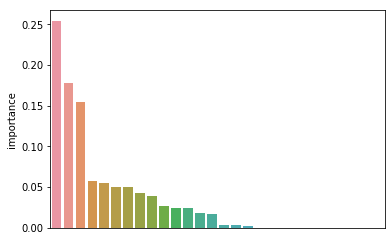

In [80]:
sns.barplot(x='index', y='importance', data=importance.reset_index())
plt.gca().get_xaxis().set_visible(False)

In [127]:
tree = clf if isinstance(clf, DecisionTreeClassifier) else clf.estimators_[0]

print_tree(tree, feature_names=X.columns, class_names=y.cat.categories)

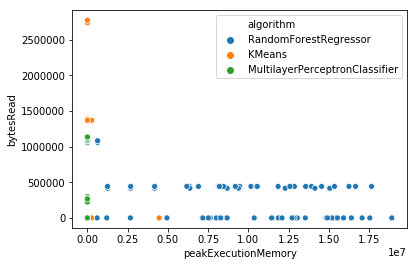

In [82]:
sns.scatterplot(x='peakExecutionMemory', y='bytesRead', hue='algorithm', data=drugs)

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


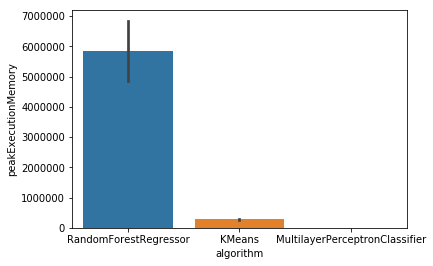

In [83]:
sns.barplot(x='algorithm', y='peakExecutionMemory', data=drugs)

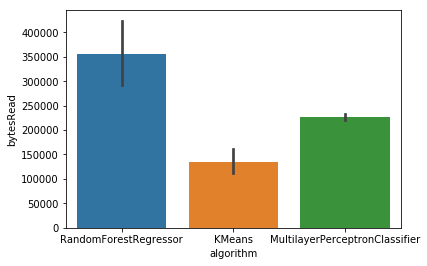

In [84]:
sns.barplot(x='algorithm', y='bytesRead', data=drugs)

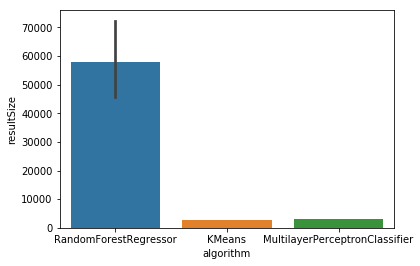

In [85]:
sns.barplot(x='algorithm', y='resultSize', data=drugs)